# 取引所毎の価格差
## 環境設定

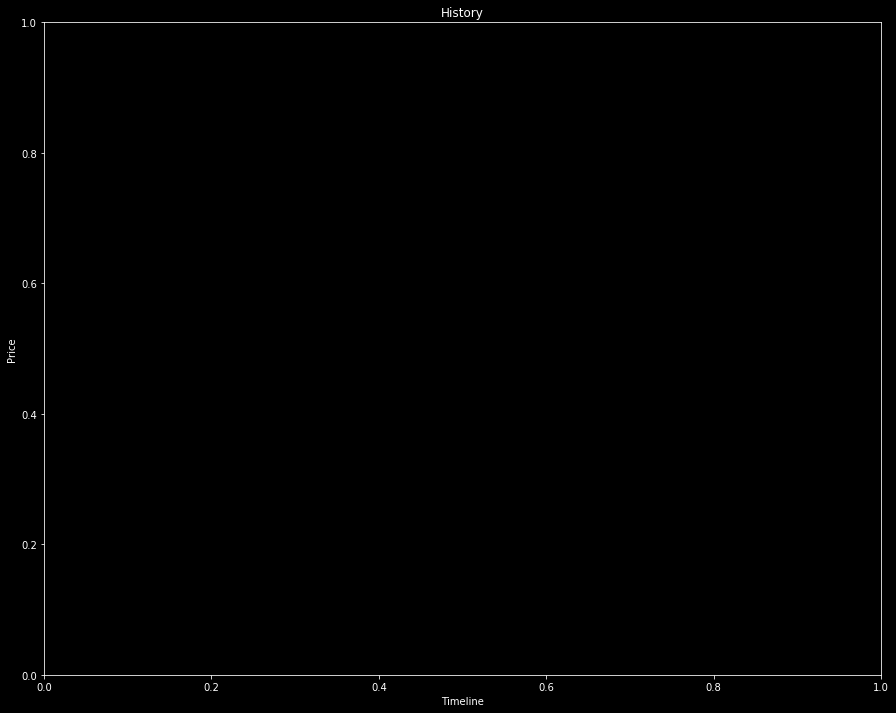

In [10]:
MYPROJECT = '/home/notebooks'
import os, sys
sys.path.insert(0, MYPROJECT)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")
import django
django.setup()
from bot.models import Exchange
import pandas as pd

### matplotlib
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from django_pandas.io import read_frame
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 12
plt.title("History")
plt.ylabel('Price')
plt.xlabel('Timeline')

### Timezone
from datetime import datetime, timedelta
from django.utils import timezone
import pytz
timezone.now()
first_date = datetime(2018, 6, 18, tzinfo=pytz.UTC)
last_date = datetime(2018, 6, 25, tzinfo=pytz.UTC)

## リサンプリング

In [11]:
bitflyer = read_frame(
    Exchange.objects.filter(
        name=Exchange.BF, created_at__range=(first_date, last_date)).order_by('created_at')[:10])
bitflyer

id      name btc_jpy_ask btc_usd_ask btc_jpy_bid btc_usd_bid  \
0  30056  Bitflyer   716980.00     6452.82   716812.00     6451.31   
1  30064  Bitflyer   716812.00     6451.31   716688.00     6450.19   
2  30072  Bitflyer   716716.00     6450.44   716633.00     6449.70   
3  30080  Bitflyer   716458.00     6448.12   716201.00     6445.81   
4  30088  Bitflyer   716396.00     6447.56   715977.00     6443.79   
5  30096  Bitflyer   716348.00     6447.13   716276.00     6446.48   
6  30104  Bitflyer   716942.00     6452.48   716868.00     6451.81   
7  30112  Bitflyer   717000.00     6453.00   716871.00     6451.84   
8  30120  Bitflyer   717169.00     6454.52   717000.00     6453.00   
9  30128  Bitflyer   716834.00     6451.51   716827.00     6451.44   

                        created_at                       updated_at  
0 2018-06-18 00:00:13.589737+00:00 2018-06-18 00:00:13.589796+00:00  
1 2018-06-18 00:01:42.223886+00:00 2018-06-18 00:01:42.223941+00:00  
2 2018-06-18 00:02:15.009717+00:00 2018-06-18 00:02:15.009779+00:00  
3 2018-06-18 00:03:10.826896+00:00 2018-06-18 00:03:10.826956+00:00  
4 2018-06-18 00:04:39.344336+00:00 2018-06-18 00:04:39.344393+00:00  
5 2018-06-18 00:06:07.748990+00:00 2018-06-18 00:06:07.749049+00:00  
6 2018-06-18 00:07:37.623127+00:00 2018-06-18 00:07:37.623184+00:00  
7 2018-06-18 00:09:07.323599+00:00 2018-06-18 00:09:07.323657+00:00  
8 2018-06-18 00:10:38.101876+00:00 2018-06-18 00:10:38.101936+00:00  
9 2018-06-18 00:12:10.429524+00:00 2018-06-18 00:12:10.429580+00:00

In [12]:
bitflyer = read_frame(Exchange.objects \
    .filter(name=Exchange.BF, created_at__range=(first_date, last_date)) \
    .extra(select={'time': "strftime('%%Y-%%m-%%d %%H:%%M', created_at)"}) \
    .values('btc_jpy_bid', 'time') \
    .order_by('time')[:10]
                     , index_col='time')
bitflyer

btc_jpy_bid
time                        
2018-06-18 00:00   716812.00
2018-06-18 00:01   716688.00
2018-06-18 00:02   716633.00
2018-06-18 00:03   716201.00
2018-06-18 00:04   715977.00
2018-06-18 00:06   716276.00
2018-06-18 00:07   716868.00
2018-06-18 00:09   716871.00
2018-06-18 00:10   717000.00
2018-06-18 00:12   716827.00

In [13]:
bitflyer = bitflyer[~bitflyer.index.duplicated(keep='first')]
bitflyer

btc_jpy_bid
time                        
2018-06-18 00:00   716812.00
2018-06-18 00:01   716688.00
2018-06-18 00:02   716633.00
2018-06-18 00:03   716201.00
2018-06-18 00:04   715977.00
2018-06-18 00:06   716276.00
2018-06-18 00:07   716868.00
2018-06-18 00:09   716871.00
2018-06-18 00:10   717000.00
2018-06-18 00:12   716827.00

In [14]:
bitflyer.index = pd.to_datetime(bitflyer.index)
bitflyer.resample('T').fillna(method='ffill')

btc_jpy_bid
time                           
2018-06-18 00:00:00   716812.00
2018-06-18 00:01:00   716688.00
2018-06-18 00:02:00   716633.00
2018-06-18 00:03:00   716201.00
2018-06-18 00:04:00   715977.00
2018-06-18 00:05:00   715977.00
2018-06-18 00:06:00   716276.00
2018-06-18 00:07:00   716868.00
2018-06-18 00:08:00   716868.00
2018-06-18 00:09:00   716871.00
2018-06-18 00:10:00   717000.00
2018-06-18 00:11:00   717000.00
2018-06-18 00:12:00   716827.00

In [15]:
def make_subset(exchange: Exchange, first_date: datetime, last_date: datetime) -> pd.DataFrame:
    ex = Exchange.objects \
        .filter(name=exchange, created_at__range=(first_date, last_date)) \
        .extra(select={'time': "strftime('%%Y-%%m-%%d %%H:%%M', created_at)"}) \
        .values('time', 'btc_jpy_bid', 'btc_jpy_ask', 'created_at') \
        .order_by('time')
    rf = read_frame(ex, index_col='time')
    rf = rf[~rf.index.duplicated(keep='first')]
    rf.index = pd.to_datetime(rf.index)
    return rf.resample('T').fillna(method='ffill')

## 各取引所のデータを移動平均に変換

In [16]:
ploniex = make_subset(Exchange.PN, first_date, last_date)
coincheck = make_subset(Exchange.CC, first_date, last_date)
zaif = make_subset(Exchange.Z, first_date, last_date)
binance = make_subset(Exchange.B, first_date, last_date)
bitflyer = make_subset(Exchange.BF, first_date, last_date)
ask_bitflyer = pd.Series.rolling(bitflyer['btc_jpy_ask'], 60 * 3).mean()
ask_ploniex = pd.Series.rolling(ploniex['btc_jpy_ask'], 60 * 3).mean()
ask_coincheck = pd.Series.rolling(coincheck['btc_jpy_ask'], 60 * 3).mean()
ask_zaif = pd.Series.rolling(zaif['btc_jpy_ask'], 60 * 3).mean()
ask_binance = pd.Series.rolling(binance['btc_jpy_ask'], 60 * 3).mean()
ploniex = ploniex.set_index('created_at')
coincheck = coincheck.set_index('created_at')
zaif = zaif.set_index('created_at')
binance = binance.set_index('created_at')
bitflyer = bitflyer.set_index('created_at')

## Plot出力

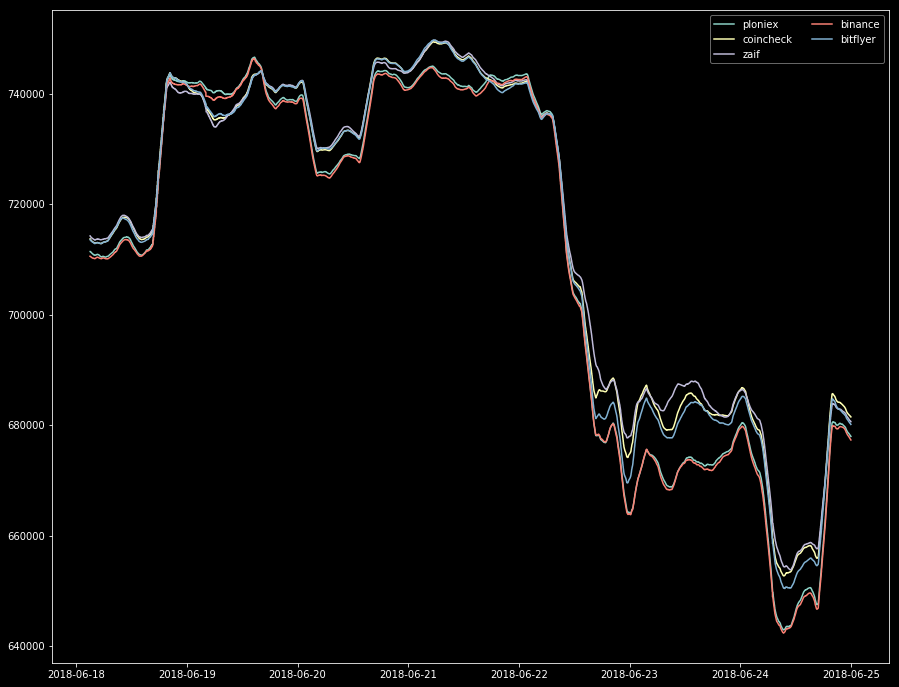

In [17]:
plt.plot(ploniex.index, ask_ploniex, color='C0', label="ploniex")
plt.plot(coincheck.index, ask_coincheck, color='C1', label="coincheck")
plt.plot(zaif.index, ask_zaif, color='C2', label="zaif")
plt.plot(binance.index, ask_binance, color='C3', label="binance")
plt.plot(bitflyer.index, ask_bitflyer, color='C4', label="bitflyer")
leg = plt.legend(loc='best', ncol=2, shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)